preprocessing
vectorization - converting text to numeric
    tfidf
    Word2vec
    glove
    Bert (https://www.kdnuggets.com/2022/01/finetuning-bert-tweets-classification-ft-hugging-face.html)
    Fastext
    Elmo
    XLNet
    Transformers (https://pub.towardsai.net/text-classification-using-transformers-a2c6b3395ce3)
Reduce the dimensions
    Principal Component Analysis
    Singular Value Decomposition
    Latent Semantic Indexing
    Pooling
    multi-dimensional scaling
calculate imbalanced ratio and find an oversampling ratio
oversample the imbalanced dataset using unlabeled data
    define a similarity function
(extension) define a strategy to choose unlabeled instances wisely to reduce computation time
    clustering?
    LDA
    Non-negative Matrix Factorization
    K-NN based graph approach (2 paper’s approaches)
it should be trained to maximize the within-class similarity while minimizing between-class similarity using labeled data using the labeled data
using the defined similarity function calculate similarity for each unlabeled instance of each class
define a similarity function
similarity functions for vectors
    Measurement of Text Similarity: A Survey: a very detailed survey of similarity functions that are used for text data
    cosine similarity
    minkowski family (euclidean, manhattan)
    hamming distance
    Jaccard index
    Sorensen-dice index
    KL divergence
    Jensen–Shannon divergence with LDA
    Wasserstein distance
    SMTP 
    word mover’s distance
to each labeled instance (possible to create a confidence)
take the average of the similarity
take the min max average and std and decide using these
to each class centroids (generalization)
use all instances
use only the instances that are similar to each other to ensure data confidence (excluding outliers)
if the similarity exceeds some defined threshold assign them to related classes
train a classifier and look for an improvement

clustering approach
does one vs rest classifier work?
if it works use self-supervised methods
Train a final classifier with oversampled data

Experimentation with different datasets
ANOVA for parameters to select important parameters
Tune important parameters to enhance performance
Compare the two cases to show the improvement
Compare with different solutions?


In [1]:
import pandas as pd
import numpy as np
import preprocess
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
col_names = ['Data Retention', 'Data Security', 'Do Not Track',
       'First Party Collection/Use', 'International and Specific Audiences',
       'Introductory/Generic', 'Policy Change', 'Practice not covered',
       'Privacy contact information', 'Third Party Sharing/Collection',
       'User Access, Edit and Deletion', 'User Choice/Control']

In [3]:
majority_path = r'C:\Users\IsmailKaraman\workspace\data\privacy_policy_data\OPP-115_v2\majority.csv'

In [4]:
df = pd.read_csv(majority_path)

In [5]:
df.head()

,text,Data Retention,Data Security,Do Not Track,First Party Collection/Use,International and Specific Audiences,Introductory/Generic,Policy Change,Practice not covered,Privacy contact information,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control
0,"""""Contact Us"""" Link If you contact us through...",0,0,0,1,0,0,0,0,0,0,0,0
1,(b) Information automatically collected There...,0,0,0,1,0,0,0,0,0,0,0,0
2,(ii) You have entered a contest or sweepstake...,0,0,0,0,0,0,0,0,0,1,0,0
3,*Web Beacons: Military Web pages and the Web ...,0,0,0,1,0,0,0,0,0,1,0,0
4,1. INFORMATION WE COLLECT We collect the foll...,0,0,0,0,0,1,0,0,0,0,0,0


In [6]:
data_dist = df[col_names].sum()
data_dist

Data Retention                            78
Data Security                            207
Do Not Track                              31
First Party Collection/Use              1181
International and Specific Audiences     296
Introductory/Generic                     378
Policy Change                            116
Practice not covered                     129
Privacy contact information              202
Third Party Sharing/Collection           931
User Access, Edit and Deletion           147
User Choice/Control                      352
dtype: int64

<AxesSubplot:>

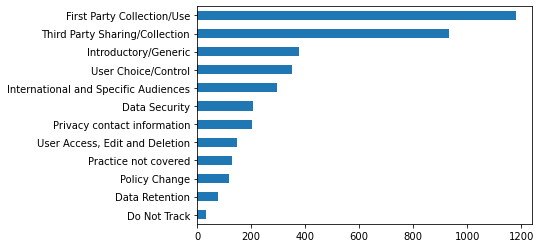

In [7]:
data_dist.sort_values().plot(kind='barh')

<AxesSubplot:>

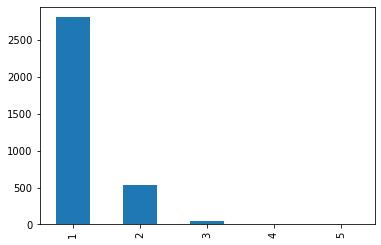

In [8]:
df[col_names].sum(axis=1).value_counts().plot(kind='bar')

In [9]:
df.shape

(3399, 13)

In [10]:
# preprocessing text data
df['text'] = df['text'].apply(preprocess.preprocess_text)

In [11]:
X = df['text']
y = df[col_names]

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X).toarray()

# a base classifier

In [13]:
def print_losses(y_test, preds, clf):
     
    print("\033[1m" + clf + ' results: ' + "\033[0m")
    print('----------------------')
    hamLoss = hamming_loss(y_test.values, preds)
    print('hamLoss: {:.2f}'.format(hamLoss))
    acc_score = accuracy_score(y_test.values, preds)
    print('Exact Match Ratio: {:.2f}'.format(acc_score))
    print('-----------------------------------------------')
    print("\033[1m" + 'Classification Report' + "\033[0m")
    print(classification_report(y_test.values, preds, target_names=list(y_test.columns)))
    print('--------------------------------------------------------------------------------------------')
    print()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = []
    for i in range(number_dim):
        weights.append(dict(zip([0,1], compute_class_weight('balanced', [0.,1.], y_true[:, i]))))
        # weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])))
    return weights

In [17]:
class_weights = calculating_class_weights(y.values)
class_weights

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0.0, 1.0], y=[1 1 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[{0: 0.511743450767841, 1: 21.78846153846154},
 {0: 0.5324248120300752, 1: 8.210144927536232},
 {0: 0.5046021377672208, 1: 54.82258064516129},
 {0: 0.7662308385933273, 1: 1.439034716342083},
 {0: 0.5476957782790848, 1: 5.741554054054054},
 {0: 0.5625620655412115, 1: 4.496031746031746},
 {0: 0.5176667681998173, 1: 14.650862068965518},
 {0: 0.5197247706422018, 1: 13.174418604651162},
 {0: 0.5315921176102596, 1: 8.413366336633663},
 {0: 0.688614262560778, 1: 1.8254564983888293},
 {0: 0.5226014760147601, 1: 11.561224489795919},
 {0: 0.5577617328519856, 1: 4.828125}]

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html

# Linear SVM
linearSvm = OneVsRestClassifier(LinearSVC(class_weight='balanced'), n_jobs=-1)
linearSvm.fit(X_train, y_train.values)
linearSvm_preds = linearSvm.predict(X_test)
print_losses(y_test, linearSvm_preds, 'Linear SVM Classifier')

# SVM
svmClassifier = OneVsRestClassifier(SVC(class_weight='balanced'), n_jobs=-1)
svmClassifier.fit(X_train, y_train.values)
svmPreds = svmClassifier.predict(X_test)
print_losses(y_test, svmPreds, 'SVM Classifier')

# Decision Tree
dtc = OneVsRestClassifier(DecisionTreeClassifier(class_weight='balanced'), n_jobs=-1)
dtc.fit(X_train, y_train.values)
dtc_preds = dtc.predict(X_test)
print_losses(y_test, dtc_preds, 'Decision Tree Classifier')

# Naive Bayes
nbc = OneVsRestClassifier(GaussianNB(), n_jobs=-1)
nbc.fit(X_train, y_train.values)
nbc_preds = nbc.predict(X_test)
print_losses(y_test, nbc_preds, 'Naive Bayes Classifier')

Linear SVM Classifier results: 
----------------------
hamLoss: 0.05
Exact Match Ratio: 0.58
-----------------------------------------------
Classification Report
                                      precision    recall  f1-score   support

                      Data Retention       0.40      0.18      0.25        11
                       Data Security       0.85      0.75      0.80        44
                        Do Not Track       1.00      0.75      0.86         8
          First Party Collection/Use       0.80      0.86      0.83       237
International and Specific Audiences       0.87      0.92      0.89        60
                Introductory/Generic       0.62      0.73      0.67        75
                       Policy Change       0.77      0.85      0.81        27
                Practice not covered       0.33      0.30      0.32        23
         Privacy contact information       0.67      0.75      0.71        32
      Third Party Sharing/Collection       0.75      0.7

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Classifier results: 
----------------------
hamLoss: 0.04
Exact Match Ratio: 0.61
-----------------------------------------------
Classification Report
                                      precision    recall  f1-score   support

                      Data Retention       1.00      0.18      0.31        11
                       Data Security       0.93      0.57      0.70        44
                        Do Not Track       1.00      0.62      0.77         8
          First Party Collection/Use       0.83      0.88      0.85       237
International and Specific Audiences       0.96      0.83      0.89        60
                Introductory/Generic       0.75      0.57      0.65        75
                       Policy Change       0.92      0.81      0.86        27
                Practice not covered       0.33      0.09      0.14        23
         Privacy contact information       0.88      0.66      0.75        32
      Third Party Sharing/Collection       0.82      0.73      

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Classifier results: 
----------------------
hamLoss: 0.08
Exact Match Ratio: 0.40
-----------------------------------------------
Classification Report
                                      precision    recall  f1-score   support

                      Data Retention       0.40      0.55      0.46        11
                       Data Security       0.60      0.61      0.61        44
                        Do Not Track       0.83      0.62      0.71         8
          First Party Collection/Use       0.65      0.72      0.68       237
International and Specific Audiences       0.83      0.90      0.86        60
                Introductory/Generic       0.46      0.57      0.51        75
                       Policy Change       0.62      0.74      0.68        27
                Practice not covered       0.18      0.30      0.23        23
         Privacy contact information       0.40      0.72      0.51        32
      Third Party Sharing/Collection       0.71      

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes Classifier results: 
----------------------
hamLoss: 0.16
Exact Match Ratio: 0.20
-----------------------------------------------
Classification Report
                                      precision    recall  f1-score   support

                      Data Retention       0.00      0.00      0.00        11
                       Data Security       0.32      0.59      0.41        44
                        Do Not Track       0.14      0.12      0.13         8
          First Party Collection/Use       0.50      0.76      0.60       237
International and Specific Audiences       0.30      0.52      0.38        60
                Introductory/Generic       0.31      0.51      0.38        75
                       Policy Change       0.32      0.44      0.37        27
                Practice not covered       0.04      0.09      0.05        23
         Privacy contact information       0.23      0.56      0.32        32
      Third Party Sharing/Collection       0.36      0.

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
y.sum()

Data Retention                            78
Data Security                            207
Do Not Track                              31
First Party Collection/Use              1181
International and Specific Audiences     296
Introductory/Generic                     378
Policy Change                            116
Practice not covered                     129
Privacy contact information              202
Third Party Sharing/Collection           931
User Access, Edit and Deletion           147
User Choice/Control                      352
dtype: int64

### preparing labeled, unlabeled set

In [20]:
X = df['text']
y = df[col_names]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
y_train.sum()

Data Retention                           67
Data Security                           163
Do Not Track                             23
First Party Collection/Use              944
International and Specific Audiences    236
Introductory/Generic                    303
Policy Change                            89
Practice not covered                    106
Privacy contact information             170
Third Party Sharing/Collection          750
User Access, Edit and Deletion          128
User Choice/Control                     273
dtype: int64

In [23]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=0.5, random_state=2)

In [24]:
y_train.sum()/y_test.sum()

Data Retention                          6.090909
Data Security                           3.704545
Do Not Track                            2.875000
First Party Collection/Use              3.983122
International and Specific Audiences    3.933333
Introductory/Generic                    4.040000
Policy Change                           3.296296
Practice not covered                    4.608696
Privacy contact information             5.312500
Third Party Sharing/Collection          4.143646
User Access, Edit and Deletion          6.736842
User Choice/Control                     3.455696
dtype: float64

In [25]:
y_labeled.sum()/y_unlabeled.sum()

Data Retention                          1.093750
Data Security                           1.063291
Do Not Track                            0.769231
First Party Collection/Use              1.088496
International and Specific Audiences    0.950413
Introductory/Generic                    0.847561
Policy Change                           0.854167
Practice not covered                    1.078431
Privacy contact information             0.868132
Third Party Sharing/Collection          0.953125
User Access, Edit and Deletion          0.969231
User Choice/Control                     0.844595
dtype: float64

In [26]:
y_labeled.sum()

Data Retention                           35
Data Security                            84
Do Not Track                             10
First Party Collection/Use              492
International and Specific Audiences    115
Introductory/Generic                    139
Policy Change                            41
Practice not covered                     55
Privacy contact information              79
Third Party Sharing/Collection          366
User Access, Edit and Deletion           63
User Choice/Control                     125
dtype: int64

In [27]:
# # of labels: min, max, average numbers
y_labeled.sum().min(), y_labeled.sum().max(), y_labeled.sum().mean()

(10, 492, 133.66666666666666)

### tf-idf similarity

In [28]:
def vector_similarity(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0:
        norm1 += 0.00001
    if norm2 == 0:
        norm2 += 0.00001 
        
    return np.dot(vec1, vec2)/(norm1*norm2)

In [29]:
def vector_similarity(text1, text2):
    
    from sentence_transformers import util
    
    embedding1 = model.encode(text1, convert_to_tensor=False, device=device)
    embedding2 = model.encode(text2, convert_to_tensor=False, device=device)
    # compute similarity scores of two embeddings
    cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)

    return cosine_scores

In [30]:
def calculate_average_similarity(vecs):
    
    similarities = []
    
    from itertools import combinations
    
    for i,j in list(combinations(vecs.index, 2)):
        similarities.append(vector_similarity(vecs.loc[i], vecs.loc[j]))    
        # similarities[(i, j)] = vector_similarity(vecs.loc[i], vecs.loc[j])
            
    try:
        avg_similarity = sum(similarities)/len(similarities)
    except AssertionErrors:
        print('Error occured')
        
    return avg_similarity 

In [31]:
from sentence_transformers import SentenceTransformer
import numpy as np
model = SentenceTransformer('stsb-roberta-large')
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [39]:
y_labeled[y_labeled['Data Retention']==1].index

Int64Index([1874, 3263, 2546, 2463, 1659, 3094, 2304, 1260, 1603, 1117,  319,
            1550,  786, 1034, 2602, 2296, 3293, 3093, 1033, 2900, 1936, 3315,
            3361, 1661,  561, 1601,   75, 1119, 3292,  735, 1704, 2597, 1240,
            1678, 2075],
           dtype='int64')

for label in ['Data Retention', 'Data Security', 'Policy Change']:
    
    print(label)
    indexes = y_labeled[y_labeled[label]==1].index
    print(calculate_average_similarity(X_labeled.loc[indexes]))

calculate_average_similarity(X_labeled.loc[y_labeled[['Data Retention', 'Data Security', 'Policy Change']].index])

In [41]:
for col in ['Data Retention', 'Data Security']:
    print(col)
    print('*'*100)
    for i in y_labeled[y_labeled[col]==1].index:
        for j in y_labeled[y_labeled['Data Security']==1].index:
            print(calculate_average_similarity(X_labeled.loc[[i,j]]))

Data Retention
****************************************************************************************************
tensor([[0.2449]])
tensor([[0.4355]])
tensor([[0.2544]])
tensor([[0.2367]])
tensor([[0.3478]])
tensor([[0.0527]])
tensor([[0.2977]])
tensor([[0.1506]])
tensor([[0.2201]])
tensor([[0.1889]])
tensor([[0.2863]])
tensor([[0.1812]])
tensor([[0.3803]])
tensor([[0.4588]])
tensor([[0.4023]])
tensor([[0.1699]])
tensor([[0.3153]])
tensor([[0.2221]])
tensor([[0.2610]])
tensor([[0.2915]])
tensor([[0.2246]])
tensor([[0.2196]])
tensor([[0.1711]])
tensor([[0.2158]])
tensor([[0.1916]])
tensor([[0.2246]])
tensor([[0.2218]])
tensor([[0.1409]])
tensor([[0.3154]])
tensor([[0.1819]])
tensor([[0.3549]])
tensor([[0.2919]])
tensor([[0.2106]])
tensor([[0.1588]])
tensor([[0.3159]])
tensor([[0.2880]])
tensor([[0.1760]])
tensor([[0.0933]])
tensor([[0.2476]])
tensor([[0.2160]])
tensor([[0.0889]])
tensor([[0.2396]])
tensor([[0.2204]])
tensor([[0.2845]])
tensor([[0.2840]])
tensor([[0.2278]])
tensor([[0

tensor([[0.5613]])
tensor([[0.3699]])
tensor([[0.5877]])
tensor([[0.4493]])
tensor([[0.5510]])
tensor([[0.0985]])
tensor([[0.4382]])
tensor([[0.3493]])
tensor([[0.5801]])
tensor([[0.4423]])
tensor([[0.5328]])
tensor([[0.3925]])
tensor([[0.4369]])
tensor([[0.5144]])
tensor([[0.4954]])
tensor([[0.6299]])
tensor([[0.4410]])
tensor([[0.5010]])
tensor([[0.4155]])
tensor([[0.5449]])
tensor([[0.5319]])
tensor([[0.3570]])
tensor([[0.5656]])
tensor([[0.5112]])
tensor([[0.3485]])
tensor([[0.4074]])
tensor([[0.5010]])
tensor([[0.3988]])
tensor([[0.3517]])
tensor([[0.5074]])
tensor([[0.6703]])
tensor([[0.5028]])
tensor([[0.5372]])
tensor([[0.5443]])
tensor([[0.6539]])
tensor([[0.4106]])
tensor([[0.4790]])
tensor([[0.4947]])
tensor([[0.5948]])
tensor([[0.5464]])
tensor([[0.5213]])
tensor([[0.4235]])
tensor([[0.4921]])
tensor([[0.4187]])
tensor([[0.4840]])
tensor([[0.5574]])
tensor([[0.4272]])
tensor([[0.5188]])
tensor([[0.4332]])
tensor([[0.5254]])
tensor([[0.6095]])
tensor([[0.5722]])
tensor([[0.6

tensor([[0.2446]])
tensor([[0.5198]])
tensor([[0.3027]])
tensor([[0.2697]])
tensor([[0.4296]])
tensor([[0.3188]])
tensor([[0.2757]])
tensor([[0.1683]])
tensor([[0.3220]])
tensor([[0.2402]])
tensor([[0.3893]])
tensor([[0.2089]])
tensor([[0.3283]])
tensor([[0.3708]])
tensor([[0.3583]])
tensor([[0.3746]])
tensor([[0.3369]])
tensor([[0.1935]])
tensor([[0.2696]])
tensor([[0.2832]])
tensor([[0.3011]])
tensor([[0.3024]])
tensor([[0.3659]])
tensor([[0.1759]])
tensor([[0.3054]])
tensor([[0.2769]])
tensor([[0.3962]])
tensor([[0.2842]])
tensor([[0.2769]])
tensor([[0.3022]])
tensor([[0.2623]])
tensor([[0.3379]])
tensor([[0.3132]])
tensor([[0.3005]])
tensor([[0.2701]])
tensor([[0.3728]])
tensor([[0.3081]])
tensor([[0.2787]])
tensor([[0.2722]])
tensor([[0.3916]])
tensor([[0.1297]])
tensor([[0.3031]])
tensor([[0.3877]])
tensor([[0.3625]])
tensor([[0.3090]])
tensor([[0.3487]])
tensor([[0.2559]])
tensor([[0.3788]])
tensor([[0.3832]])
tensor([[0.2914]])
tensor([[0.1491]])
tensor([[0.4306]])
tensor([[0.3

tensor([[0.4134]])
tensor([[0.3226]])
tensor([[0.3248]])
tensor([[0.3881]])
tensor([[0.3760]])
tensor([[0.3025]])
tensor([[0.5516]])
tensor([[0.2492]])
tensor([[0.4505]])
tensor([[0.2649]])
tensor([[0.3211]])
tensor([[0.3396]])
tensor([[0.2906]])
tensor([[0.3301]])
tensor([[0.4602]])
tensor([[0.4197]])
tensor([[0.3586]])
tensor([[0.3581]])
tensor([[0.3834]])
tensor([[0.4823]])
tensor([[0.2626]])
tensor([[0.3807]])
tensor([[0.5018]])
tensor([[0.4332]])
tensor([[0.2271]])
tensor([[0.3620]])
tensor([[0.3045]])
tensor([[0.4136]])
tensor([[0.4098]])
tensor([[0.4748]])
tensor([[0.2845]])
tensor([[0.4420]])
tensor([[0.5325]])
tensor([[0.2924]])
tensor([[0.2510]])
tensor([[0.4286]])
tensor([[0.4155]])
tensor([[0.2743]])
tensor([[0.4286]])
tensor([[0.3924]])
tensor([[0.2825]])
tensor([[0.3635]])
tensor([[0.5212]])
tensor([[0.3677]])
tensor([[0.2588]])
tensor([[0.2590]])
tensor([[0.1444]])
tensor([[0.2482]])
tensor([[0.5295]])
tensor([[0.3951]])
tensor([[0.4949]])
tensor([[0.4604]])
tensor([[0.5

tensor([[0.3855]])
tensor([[0.3147]])
tensor([[0.3448]])
tensor([[0.1822]])
tensor([[0.3153]])
tensor([[0.1913]])
tensor([[0.2489]])
tensor([[0.2677]])
tensor([[0.2157]])
tensor([[0.1015]])
tensor([[0.3355]])
tensor([[0.3889]])
tensor([[0.2343]])
tensor([[0.2172]])
tensor([[0.2758]])
tensor([[0.2028]])
tensor([[0.4058]])
tensor([[0.3812]])
tensor([[0.2482]])
tensor([[0.2110]])
tensor([[0.5684]])
tensor([[0.2984]])
tensor([[0.1856]])
tensor([[0.4942]])
tensor([[0.3781]])
tensor([[0.0747]])
tensor([[0.2517]])
tensor([[0.4238]])
tensor([[0.2479]])
tensor([[0.4615]])
tensor([[0.2362]])
tensor([[0.1012]])
tensor([[0.2997]])
tensor([[0.5152]])
tensor([[0.6032]])
tensor([[0.4477]])
tensor([[0.4756]])
tensor([[0.4769]])
tensor([[0.3427]])
tensor([[0.4712]])
tensor([[0.3207]])
tensor([[0.3426]])
tensor([[0.4186]])
tensor([[0.4332]])
tensor([[0.3770]])
tensor([[0.3528]])
tensor([[0.5261]])
tensor([[0.4662]])
tensor([[0.3408]])
tensor([[0.4261]])
tensor([[0.4799]])
tensor([[0.4033]])
tensor([[0.6

tensor([[0.3602]])
tensor([[0.3926]])
tensor([[0.2645]])
tensor([[0.3128]])
tensor([[0.3090]])
tensor([[0.4044]])
tensor([[0.2505]])
tensor([[0.3831]])
tensor([[0.3193]])
tensor([[0.2706]])
tensor([[0.3629]])
tensor([[0.3548]])
tensor([[0.2957]])
tensor([[0.2340]])
tensor([[0.3965]])
tensor([[0.2393]])
tensor([[0.1885]])
tensor([[0.5462]])
tensor([[0.2934]])
tensor([[0.5076]])
tensor([[0.4857]])
tensor([[0.3850]])
tensor([[0.4719]])
tensor([[0.4965]])
tensor([[0.5694]])
tensor([[0.3036]])
tensor([[0.4978]])
tensor([[0.4407]])
tensor([[0.5881]])
tensor([[0.1023]])
tensor([[0.3709]])
tensor([[0.3487]])
tensor([[0.5532]])
tensor([[0.4133]])
tensor([[0.4751]])
tensor([[0.3267]])
tensor([[0.3891]])
tensor([[0.5136]])
tensor([[0.4351]])
tensor([[0.6051]])
tensor([[0.3819]])
tensor([[0.4312]])
tensor([[0.3639]])
tensor([[0.5737]])
tensor([[0.5146]])
tensor([[0.3179]])
tensor([[0.5373]])
tensor([[0.4517]])
tensor([[0.3133]])
tensor([[0.3664]])
tensor([[0.4752]])
tensor([[0.3567]])
tensor([[0.2

tensor([[0.5802]])
tensor([[0.4397]])
tensor([[0.6957]])
tensor([[0.6302]])
tensor([[0.7342]])
tensor([[0.4738]])
tensor([[0.6718]])
tensor([[0.4588]])
tensor([[0.4532]])
tensor([[0.6503]])
tensor([[0.4433]])
tensor([[0.5519]])
tensor([[0.2461]])
tensor([[0.6317]])
tensor([[0.4751]])
tensor([[0.4534]])
tensor([[0.4954]])
tensor([[0.5632]])
tensor([[0.4412]])
tensor([[0.5090]])
tensor([[0.6197]])
tensor([[0.5053]])
tensor([[0.5069]])
tensor([[0.6496]])
tensor([[0.5383]])
tensor([[0.6258]])
tensor([[0.5373]])
tensor([[0.6002]])
tensor([[0.5361]])
tensor([[0.4757]])
tensor([[0.5772]])
tensor([[0.4352]])
tensor([[0.6570]])
tensor([[0.4817]])
tensor([[0.6746]])
tensor([[0.4933]])
tensor([[0.5678]])
tensor([[0.4507]])
tensor([[0.5975]])
tensor([[0.5371]])
tensor([[0.5114]])
tensor([[0.5727]])
tensor([[0.6305]])
tensor([[0.6727]])
tensor([[0.6387]])
tensor([[0.5925]])
tensor([[0.5511]])
tensor([[0.5794]])
tensor([[0.6047]])
tensor([[0.6421]])
tensor([[0.6180]])
tensor([[0.6731]])
tensor([[0.6

KeyError: 0

In [36]:
X_labeled.loc[[2787,1899]]

2787    user account include picture usernames collect...
1899    question comment concern sally ride science pr...
Name: text, dtype: object

In [ ]:
X_labeled[1874], X_labeled[3263]

In [ ]:
model = SentenceTransformer('stsb-roberta-large')

# context based models
source: https://medium.com/nlplanet/two-minutes-nlp-11-word-embeddings-models-you-should-know-a0581763b9a9

In [ ]:
elmo

In [ ]:
cove

In [ ]:
xlm

In [ ]:
embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('stsb-roberta-large')
#Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

In [ ]:
Bert legal - https://huggingface.co/nlpaueb/legal-bert-base-uncased
'legal-bert-base-uncased'
'legal-bert-small-uncased'
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")

Roberta legal - https://huggingface.co/saibo/legal-roberta-base
'legal-roberta-base'
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("saibo/legal-roberta-base")
model = AutoModel.from_pretrained("saibo/legal-roberta-base")

Albert - https://huggingface.co/albert-base-v2
'albert-base-v2'
'ALBERT-xlarge'
'ALBERT-xxlarge'
from transformers import AlbertTokenizer, AlbertModel
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertModel.from_pretrained("albert-base-v2")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

XLM - https://huggingface.co/sentence-transformers/paraphrase-xlm-r-multilingual-v1

Sentence transformers

from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]
model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
embeddings = model.encode(sentences)
print(embeddings)


all-MiniLM-L12-v2 - https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2
all-mpnet-base-v2 - https://huggingface.co/sentence-transformers/all-mpnet-base-v2
all-distilroberta-v1 - https://huggingface.co/sentence-transformers/all-distilroberta-v1
multi-qa-mpnet-base-dot-v1 - https://huggingface.co/sentence-transformers/multi-qa-mpnet-base-dot-v1

### fine-tuning sentence-embedding models

it is possible to fine-tune sentence similarity models by using cosine similarity loss function. 
some pair of sentences and similarity between them are given as training data and models can be fine-tuned
by using in-class similarity as high score and between-class similarity as low score we can tune the model to find more instances by the similarity

https://www.sbert.net/docs/training/overview.html

In [ ]:
sentence1 = "I like Python because I can build AI applications"
sentence2 = "I like Python because I can do data analytics"
# encode sentences to get their embeddings
embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

In [ ]:
sentences1 = ["I like Python because I can build AI applications", "The cat sits on the ground"]   
sentences2 = ["I like Python because I can do data analytics", "The cat walks on the sidewalk"]
# encode list of sentences to get their embeddings
embedding1 = model.encode(sentences1, convert_to_tensor=True)
embedding2 = model.encode(sentences2, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
for i in range(len(sentences1)):
    for j in range(len(sentences2)):
        print("Sentence 1:", sentences1[i])
        print("Sentence 2:", sentences2[j])
        print("Similarity Score:", cosine_scores[i][j].item())
        print()

In [ ]:
corpus = ["I like Python because I can build AI applications",
          "I like Python because I can do data analytics",
          "The cat sits on the ground",
         "The cat walks on the sidewalk"]

query = "I like Javascript because I can build web applications"

In [ ]:

# encode corpus to get corpus embeddings
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)
sentence = "I like Javascript because I can build web applications"
# encode sentence to get sentence embeddings
sentence_embedding = model.encode(sentence, convert_to_tensor=True)
# top_k results to return
top_k=2
# compute similarity scores of the sentence with the corpus
cos_scores = util.pytorch_cos_sim(sentence_embedding, corpus_embeddings)[0]
# Sort the results in decreasing order and get the first top_k
top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k]
print("Sentence:", sentence, "\n")
print("Top", top_k, "most similar sentences in corpus:")
for idx in top_results[0:top_k]:
    print(corpus[idx], "(Score: %.4f)" % (cos_scores[idx]))

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

search_terms = 'fruit and vegetables'
documents = ['cars drive on the road', 'tomatoes are actually fruit']

doc_vectors = TfidfVectorizer().fit_transform([search_terms] + documents)

cosine_similarities = linear_kernel(doc_vectors[0:1], doc_vectors).flatten()
document_scores = [item.item() for item in cosine_similarities[1:]]
document_scores

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

# Download stopwords list
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

search_terms = 'red tomato'
documents = ['cars drive on the road', 'tomatoes are actually fruit']

# Create TF-idf model
vectorizer = TfidfVectorizer(stop_words=token_stop, 
                              tokenizer=tokenizer)
doc_vectors = vectorizer.fit_transform([search_terms] + documents)

# Calculate similarity
cosine_similarities = linear_kernel(doc_vectors[0:1], doc_vectors).flatten()
document_scores = [item.item() for item in cosine_similarities[1:]]
document_scores

In [ ]:
from re import sub
from gensim.utils import simple_preprocess
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

In [ ]:
query_string = 'fruit and vegetables'
documents = ['cars drive on the road', 'tomatoes are actually fruit']

stopwords = ['the', 'and', 'are', 'a']

# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
def preprocess(doc):
    # Tokenize, clean up input document string
    doc = sub(r'<img[^<>]+(>|$)', " image_token ", doc)
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    doc = sub(r'\[img_assist[^]]*?\]', " ", doc)
    doc = sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " url_token ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

In [ ]:
query_string = 'fruit and vegetables'
documents = ['cars drive on the road', 'tomatoes are actually fruit']

In [ ]:
documents = ["I like Python because I can build AI applications",
          "I like Python because I can do data analytics",
          "The cat sits on the ground",
         "The cat walks on the sidewalk"]

query_string = "I like Javascript because I can build web applications"

In [ ]:
# Preprocess the documents, including the query string
corpus = [preprocess(document) for document in documents]
query = preprocess(query_string)

In [ ]:
# Load the model: this is a big file, can take a while to download and open
glove = api.load("glove-wiki-gigaword-50")    
similarity_index = WordEmbeddingSimilarityIndex(glove)

# Build the term dictionary, TF-idf model
dictionary = Dictionary(corpus+[query])
tfidf = TfidfModel(dictionary=dictionary)

# Create the term similarity matrix.  
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)

In [ ]:
# Compute Soft Cosine Measure between the query and the documents.
# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
query_tf = tfidf[dictionary.doc2bow(query)]

index = SoftCosineSimilarity(
            tfidf[[dictionary.doc2bow(document) for document in corpus]],
            similarity_matrix)

doc_similarity_scores = index[query_tf]

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(doc_similarity_scores)[::-1]
for idx in sorted_indexes:
    print(f'{idx} \t {doc_similarity_scores[idx]:0.3f} \t {documents[idx]}')


In [ ]:
http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S1405-55462016000400647